In [7]:
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
from statsmodels.tsa.api import VAR

In [77]:
df_train = pd.read_hdf('data.h5', key="train")
df_val = pd.read_hdf('data.h5', key="validation")
df_test = pd.read_hdf('data.h5', key="test")

In [291]:
def get_train_val_test(feature_sets):
    for feature_set in feature_sets:
        for feature in feature_set:
            columns = [col for col in df_train.columns if col.startswith(measure + "-") and geo in col]
            return get_data(columns)

def process_data_return_VAR_Xt(df_train, df_val, df_test):

    VAR_Xt = pd.concat([df_train, df_val], axis = 0)
    t_train = df_train.shape[0]
    t_val = np.arange(t_train, t_train + df_val.shape[0])

    return VAR_Xt, t_val

def train_var(VAR_Xt,
              t_val, 
              w=365*4, 
              ar_order=2, 
              k=3):

    y_hat = []
    y_true = []

    for t in t_val:
        
        windowed_data = VAR_Xt.iloc[(t - w + 1): (t + 1), :]
        
        model = VAR(windowed_data, freq="12h").fit(ar_order)

        data_for_pred = windowed_data.values[-ar_order:]

        forecasts = model.forecast(y=data_for_pred, steps=k)

        if forecasts.shape != np.array(VAR_Xt.iloc[t+1: t+k+1]).shape:
            continue

        y_hat.append(forecasts)
        y_true.append(np.array(VAR_Xt.iloc[t+1: t+k+1]))
        
    return np.array(y_hat), np.array(y_true)


def evaluate(y_hat, y_true, metric="MSE"):
    if metric == "MSE":
        return (np.square(np.subtract(y_hat, y_true))).mean()
    # elif metric == "MAE"

def plot_outputs(outputs, n_outputs, labels):
    import matplotlib.pyplot as plt


    fig, ax = plt.subplots(nrows = n_outputs)

    fig.set_size_inches(20, 10)

    for output in range(n_outputs):
        ax[output].plot(outputs[output,0], label = labels[output,0])
        ax[output].plot(outputs[output,1], label = labels[output,1])
        ax[output].legend()

        ax[1].plot(true_t_plus_12_mae, label ="True MAE")
        ax[1].plot(forecasts_t_plus_12_mae, label = "Forecast MAE")

        ax[0].legend()
        ax[1].legend()

## The auto regressive (AR) and vector auto regression (VAR) models we intend to build

$$
\forall \quad TH \quad \forall \quad geo \quad \forall \quad measures \quad AR \\
\forall \quad TH \quad \forall \quad geo \quad VAR \quad of \quad measures \\
\forall \quad TH \quad \forall \quad measure \quad VAR \quad of \quad geos \\
\forall \quad geo \quad \forall \quad measure \quad VAR \quad of \quad THs \\
VAR \quad of \quad THs, \quad measures \quad and \quad geos \\
$$

In [78]:
def get_data(columns):
    return df_train[columns], df_val[columns], df_test[columns]

In [161]:
MSE_dict = {}

for time_horizon in range(0, 372, 6):
    for geo in ["DEU", "ITA"]:
        columns = [col for col in df_train.columns if geo in col and col.endswith("-" + str(time_horizon))]
        df_train_subset, df_val_subset, df_test_subset = get_data(columns)
        VAR_Xt, t_val = process_data_return_VAR_Xt(df_train_subset, df_val_subset, df_test_subset) 
        
        y_hat, y_true = train_var(VAR_Xt, 
                                  t_val,
                                  w=365*4, 
                                  ar_order=2, 
                                  k=3)
        
        mse = evaluate(y_hat, y_true, metric = "MSE")

        MSE_dict[time_horizon, geo] = mse

In [162]:
for time_horizon in range(0, 372, 6):
    for measure in ["model_0_value", "ens_std", "mae"]:
        columns = [col for col in df_train.columns if col.startswith(measure + "-") and col.endswith("-" + str(time_horizon))]
        df_train_subset, df_val_subset, df_test_subset = get_data(columns)

In [163]:
for geo in ["DEU", "ITA"]:
    for measure in ["model_0_value", "ens_std", "mae"]:
        columns = [col for col in df_train.columns if col.startswith(measure + "-") and geo in col]
        df_train_subset, df_val_subset, df_test_subset = get_data(columns)
        

In [293]:
def get_train_val_test(feature_sets):
    for feature_set in feature_sets:
        for feature in feature_set:
            columns = [col for col in df_train.columns if col.startswith(measure + "-") and geo in col]
            return get_data(columns)

In [248]:
y_hat, y_true = train_var()

In [255]:
mse = (np.square(np.subtract(y_hat, y_true))).mean()

In [278]:
np.arange(1, y_hat.shape[0]).shape

(2760,)

In [286]:
forecasts_t_plus_12_std = pd.DataFrame(y_hat[:, 0, 0])
true_t_plus_12_std = pd.DataFrame(y_true[:, 0, 0])
forecasts_t_plus_12_mae = pd.DataFrame(y_hat[:, 0, 1])
true_t_plus_12_mae = pd.DataFrame(y_true[:, 0, 1])

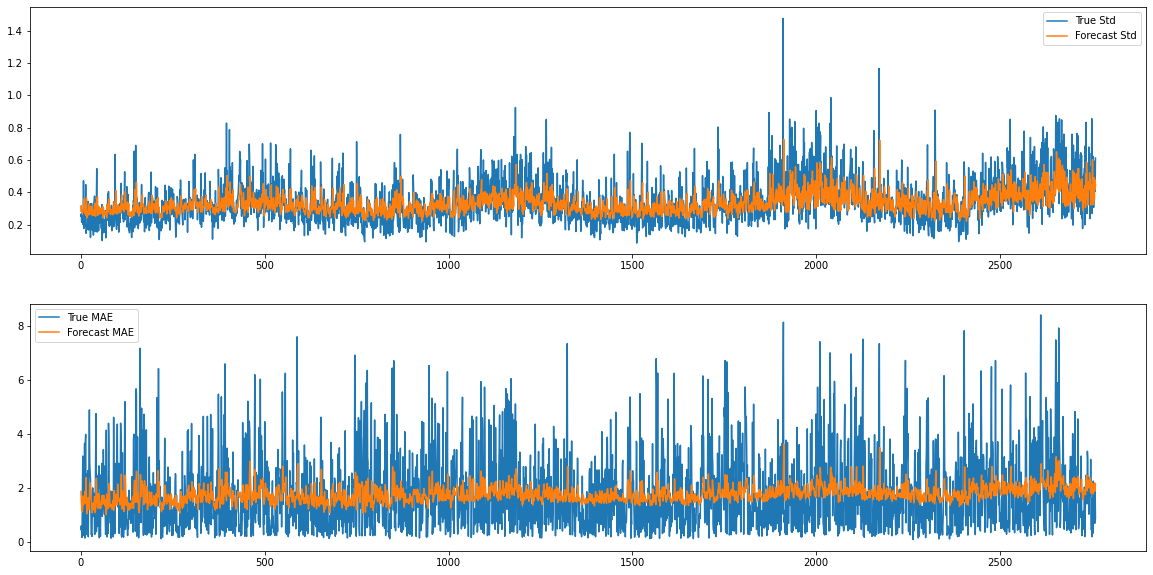

In [289]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows = 2)

fig.set_size_inches(20, 10)

ax[0].plot(true_t_plus_12_std, label ="True Std")
ax[0].plot(forecasts_t_plus_12_std, label = "Forecast Std")


ax[1].plot(true_t_plus_12_mae, label ="True MAE")
ax[1].plot(forecasts_t_plus_12_mae, label = "Forecast MAE")

ax[0].legend()
ax[1].legend()